In [1]:
from trainer import UncertaintyTrainer
import os
import numpy as np
import pandas
import torch
from module.config import loadConfig, showConfig
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from torchvision import transforms
from module.utils import accuracy
from sklearn.manifold import TSNE
from module.config import checkOutputDirectoryAndCreate
from tqdm import tqdm

gpu = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu
# legend_items = list(range(0, 10))

legend_items = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship', 'truck']
config_path = "./result/cifar_noise_sym05_ssl_adamW/config.yaml"

epoch = 129
MC_sample = 1
mean = 0
std = 0

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() and gpu != "-1" else "cpu")
config = loadConfig(config_path)
config['noise_type'] = "none"
trainer = UncertaintyTrainer(config, device)
checkOutputDirectoryAndCreate(f'{config["output_folder"]}/img')

model_path = f'result/{config["output_folder"]}/flow_{str(epoch).zfill(2)}.pt'
encoder_path = f'result/{config["output_folder"]}/encoder_{str(epoch).zfill(2)}.pt'
trainer.load(model_path)
trainer.load_encoder(encoder_path)

Files already downloaded and verified
Files already downloaded and verified
Training T : 1.0
Number of trainable parameters of Point CNF: 61265


RuntimeError: Error(s) in loading state_dict for MyResNet:
	size mismatch for model.predictor.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for model.predictor.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.predictor.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.predictor.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.predictor.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.predictor.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([64, 512]).

In [4]:
probs_val, target_val, _, probs_all_val, condition_feature_val  = trainer.sampling(trainer.val_loader, MC_sample, mean, std)
acc_list = accuracy(probs_val,  target_val, topk=(1,2))
acc_top1 = acc_list[0].cpu().item()
acc_top2 = acc_list[1].cpu().item()
print("acc top1: ", acc_top1, " top2 : ", acc_top2)

312it [00:31,  9.98it/s]

acc top1:  83.974365234375  top2 :  91.27604675292969


In [3]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, legend_items[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [6]:
def run(epoch):
    model_path = f'result/{config["output_folder"]}/flow_{str(epoch).zfill(2)}.pt'
    encoder_path = f'result/{config["output_folder"]}/encoder_{str(epoch).zfill(2)}.pt'
    trainer.load(model_path)
    trainer.load_encoder(encoder_path)
    probs_val, target_val, _, _, condition_feature_val  = trainer.sampling(trainer.val_loader, MC_sample, mean, std)
    cond_embedded = TSNE(n_components=2, verbose=1, init='random').fit_transform(condition_feature_val.numpy())
    prob_embedded = TSNE(n_components=2, verbose=1, init='random').fit_transform(probs_val.numpy())
    scatter(cond_embedded, target_val.numpy())
    path = f'./result/{config["output_folder"]}/img/cifar_cond_tsne-generated_{epoch}.png'
    plt.savefig(path, dpi=120)
    scatter(prob_embedded, target_val.numpy())
    path = f'./result/{config["output_folder"]}/img/cifar_prob_tsne-generated_{epoch}.png'
    plt.savefig(path, dpi=120)

312it [00:29, 10.41it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9984 samples in 0.001s...
[t-SNE] Computed neighbors for 9984 samples in 2.550s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 2.077628
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.770744
[t-SNE] KL divergence after 1000 iterations: 1.414622
[t-SNE] Computing 91 nearest neighbors

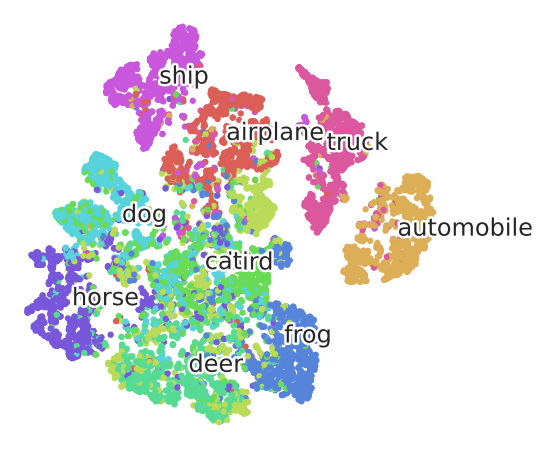

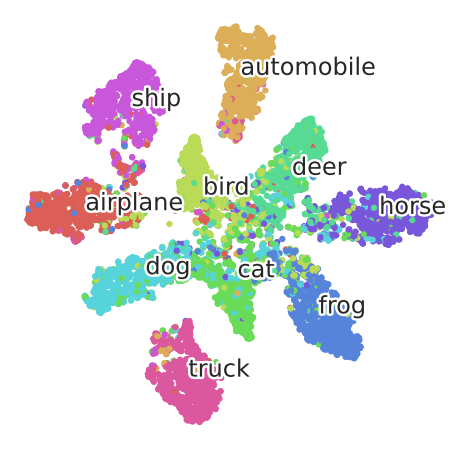

In [12]:
run(129)
# for epoch in range(0, 200, 10):
#     run(epoch)

In [9]:
def encoder_sample(config_path, loader, epoch):
    from module.resnet import MyResNet
    config_encoder = loadConfig(config_path)
    acc = 0
    encoder_path = f'result/{config_encoder["output_folder"]}/encoder_{str(epoch).zfill(2)}.pt'
    model = MyResNet(in_channels = 3, feature_dim = 512, isPredictor = True, isLinear = True, num_classes = 10).to(device)
    model.load_state_dict(torch.load(encoder_path))
    model.train()
    prob_vec = []
    target_vec = []
    feature_vec = []
    m = torch.nn.Softmax(dim=1)
    for batch_idx, (data, target) in tqdm(enumerate(loader)):
        data, target = data.to(device), target.to(device)

        output = model(data)
        feature = model.forward_flatten(data)
        pred = m(output)
        acc_batch = accuracy(pred, target)[0].cpu()
        acc += acc_batch
        feature_vec.append(feature.data.cpu())
        prob_vec.append(pred.data.cpu())
        target_vec.append(target.data.cpu())
        
    feature_vec = torch.cat(feature_vec, dim=0)
    prob_vec = torch.cat(prob_vec, dim=0)
    target_vec = torch.cat(target_vec, dim=0)
    print("acc : ",  acc / (batch_idx + 1))
    return prob_vec.data.cpu(), target_vec.data.cpu(), feature_vec.data.cpu()

In [26]:
myresnet_config = "./result/nosie_sym0.5_resnet_vic_mixup/config.yaml"
epoch_encoder = 102
prob_resnet, target_resnet, feature_resnet = encoder_sample(myresnet_config, trainer.val_loader, epoch_encoder)

312it [00:04, 73.72it/s]

acc :  tensor([81.1398])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9984 samples in 0.005s...
[t-SNE] Computed neighbors for 9984 samples in 2.635s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 0.771187
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.205734
[t-SNE] KL divergence after 1000 iterations: 1.932823


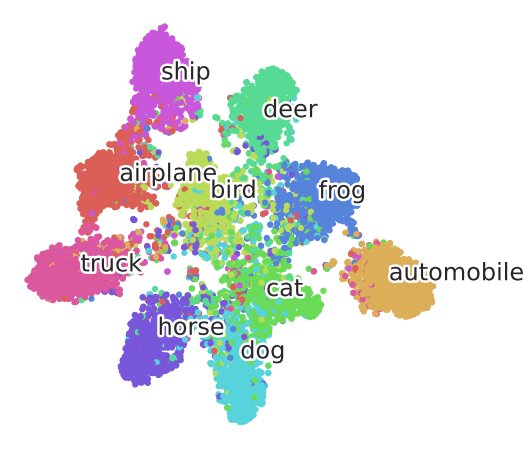

In [19]:
encoder_f_embedded = TSNE(n_components=2, verbose=1, init='random').fit_transform(feature_resnet.numpy())
scatter(encoder_f_embedded, target_resnet.numpy())
plt.savefig('tsne_encoder_f.png', dpi=120)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9984 samples in 0.042s...
[t-SNE] Computed neighbors for 9984 samples in 1.202s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 0.022242
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.918007
[t-SNE] KL divergence after 1000 iterations: 1.214368


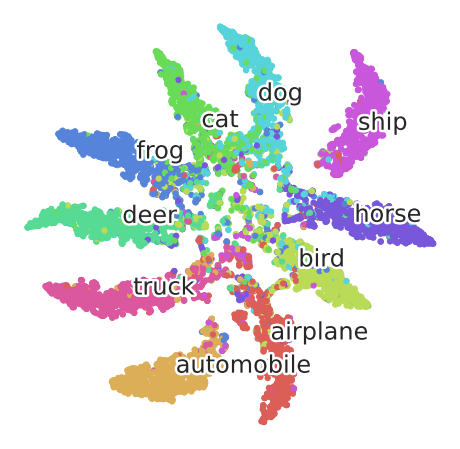

In [20]:
encoder_embedded = TSNE(n_components=2, verbose=1, init='random').fit_transform(prob_resnet.numpy())
scatter(encoder_embedded, target_resnet.numpy())
plt.savefig('tsne_encoder.png', dpi=120)